In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


### Kaggle Data

In [5]:
listings = pd.read_csv('listings.csv', parse_dates=['host_since', 'first_review', 'last_review'])
print(listings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 53 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3818 non-null   int64  
 1   name                            3818 non-null   object 
 2   summary                         3641 non-null   object 
 3   space                           3249 non-null   object 
 4   description                     3818 non-null   object 
 5   neighborhood_overview           2786 non-null   object 
 6   notes                           2212 non-null   object 
 7   transit                         2884 non-null   object 
 8   host_id                         3818 non-null   int64  
 9   host_name                       3816 non-null   object 
 10  host_since                      3816 non-null   object 
 11  host_location                   3810 non-null   object 
 12  host_response_time              32

In [14]:
# Step 1: general data cleaning
# 1_1: Check the information of the dataset
pd.set_option('display.max_columns', None)
print("There are {} entries in this dataset".format(listings.shape[0]))

# 1_3: Drop entries missing price data since entries missing price data will lose their analytical value
listings.dropna(subset=['price'], inplace=True)

# 1_4: Setting up specific cleaning procedures for different types of columns
# 1_4_a: Remove all the dollar signs or commas or % in these numeric-related columns
numeric_column = ['price', 'weekly_price', 'monthly_price', 'cleaning_fee', 'extra_people',
                  'security_deposit', 'host_response_rate', 'host_acceptance_rate']
for numeric_col in numeric_column:
    listings[numeric_col].replace('\$|,|%', '', regex=True, inplace=True)
    listings[numeric_col] = pd.to_numeric(listings[numeric_col], errors="coerce", downcast='float').fillna(0)

print(listings.info())

# 1_4_c: Convert rates into float numbers
rate_column = ['host_response_rate', 'host_acceptance_rate']
for rate_col in rate_column:
    listings[rate_col] = listings[rate_col].apply(lambda x: round(x / 100, 2))

# 1_4_d: Fill NaN cells with 0 on those numeric columns
num_listing_df = listings.select_dtypes(include=[int, np.float32, np.float64])
num_listing_df.fillna(0, inplace=True)
print(num_listing_df.info())

# 1_4_e: Fill NaN cells with "None" on those string columns
str_listing_df = listings.select_dtypes(include=['object'])
str_listing_df.fillna('None', inplace=True)

# 1_4_f: Fill 1 or 0 for the boolean value
boolean_column = ['host_is_superhost', 'host_identity_verified', 'has_availability']
for boolean_col in boolean_column:
    listings[boolean_col].replace({'t|T': 1, 'f|F': 0}, regex=True, inplace=True)

print("General data cleanning process finished!")


There are 3818 entries in this dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 53 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3818 non-null   int64  
 1   name                            3818 non-null   object 
 2   summary                         3641 non-null   object 
 3   space                           3249 non-null   object 
 4   description                     3818 non-null   object 
 5   neighborhood_overview           2786 non-null   object 
 6   notes                           2212 non-null   object 
 7   transit                         2884 non-null   object 
 8   host_id                         3818 non-null   int64  
 9   host_name                       3816 non-null   object 
 10  host_since                      3816 non-null   object 
 11  host_location                   3810 non-null   object 


<Axes: >

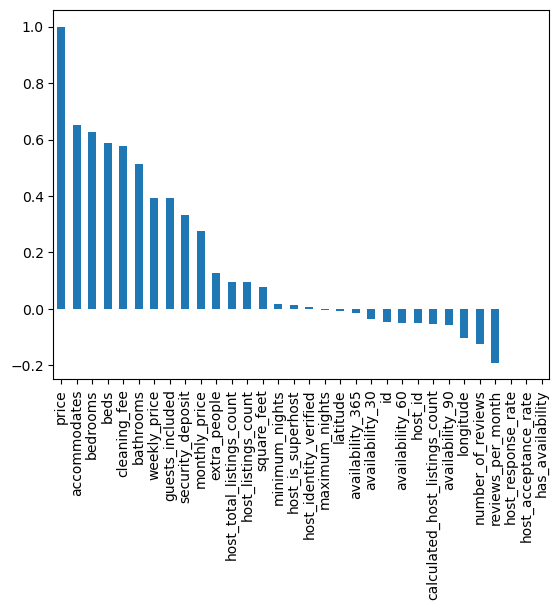

In [18]:
num_listing_df.corr()['price'].sort_values(ascending=False).plot.bar()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_30136\2108151424.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='accommodates', y='price', data=average_price_by_accommodates, palette='viridis', ci=None, capsize=0.1, errwidth=1.5, width=0.8)


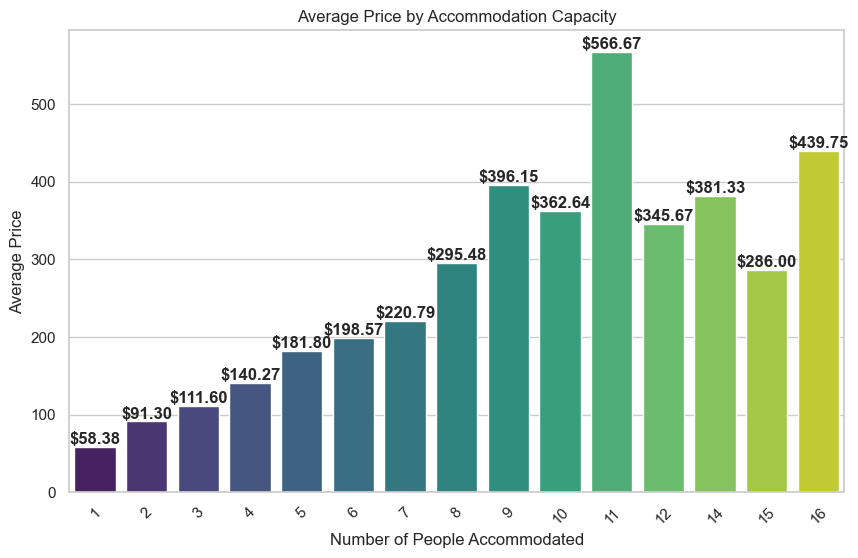

In [23]:
average_price_by_accommodates = num_listing_df.groupby('accommodates')['price'].mean().reset_index()
average_price_by_accommodates = average_price_by_accommodates.sort_values(by='accommodates')
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='accommodates', y='price', data=average_price_by_accommodates, palette='viridis', ci=None, capsize=0.1, errwidth=1.5, width=0.8)
plt.xlabel('Number of People Accommodated')
plt.ylabel('Average Price')
plt.title('Average Price by Accommodation Capacity')

# Adding labels to the bars
for index, value in enumerate(average_price_by_accommodates['price']):
    ax.text(index, value, f"${value:.2f}", ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.show()

### Foursquare Data

In [31]:
fsq = pd.read_csv('foursquare_data15-Jul-23.csv')
nbh_tab = pd.read_csv('neighbourhoods_of fsqid_tab.csv')

fsq = fsq[['fsq_id', 'venue_name', 'latitude',
       'longitude', 'verified', 'rating', 'popularity', 'price',
       'total_ratings']]
fsq['rating'] = fsq['rating'].replace(100, 0)
fsq['price']= fsq['price']= fsq['price'].replace(100, 0)
fsq['popularity'] = fsq['popularity'].replace(100, 0)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_30136\2423624371.py:2: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  nbh_tab = pd.read_csv('neighbourhoods_of fsqid_tab.csv')


In [ ]:
nbh_tab = nbh_tab[['Fsq Id','Neighbourhood Group Cleansed']]
new_column_names = {
    'Fsq Id': 'fsq_id',
    'Neighbourhood Group Cleansed': 'neighborhood_group_cleansed'
}
nbh_tab.rename(columns=new_column_names, inplace=True)
nbh_tab.columns = nbh_tab.columns.str.replace(' ', '_').str.lower()
nbh_tab = nbh_tab.drop_duplicates(subset='fsq_id', keep='first')
nbh_tab

In [36]:
nbh_tab = nbh_tab[['Fsq Id','Neighbourhood Group Cleansed']]
new_column_names = {
    'Fsq Id': 'fsq_id',
    'Neighbourhood Group Cleansed': 'neighborhood_group_cleansed'
}
nbh_tab.rename(columns=new_column_names, inplace=True)
nbh_tab.columns = nbh_tab.columns.str.replace(' ', '_').str.lower()
nbh_tab = nbh_tab.drop_duplicates(subset='fsq_id', keep='first')
nbh_tab

,fsq_id,neighborhood_group_cleansed
0,4c77edff93ef236afa74aa0f,Downtown
1,477ce324f964a520234d1fe3,Downtown
2,4f32718a19836c91c7d859f5,Downtown
4,4a984221f964a5203b2b20e3,Downtown
5,4e4dda24bd4101d0d79cc697,Downtown
...,...,...
255347,4a077e99f964a52070731fe3,Magnolia
255485,93b4e709de52450936824662,Magnolia
258131,6136a5e5f0b0af2cdcdf9053,Seward Park
258830,4afcd5def964a520352622e3,Northgate


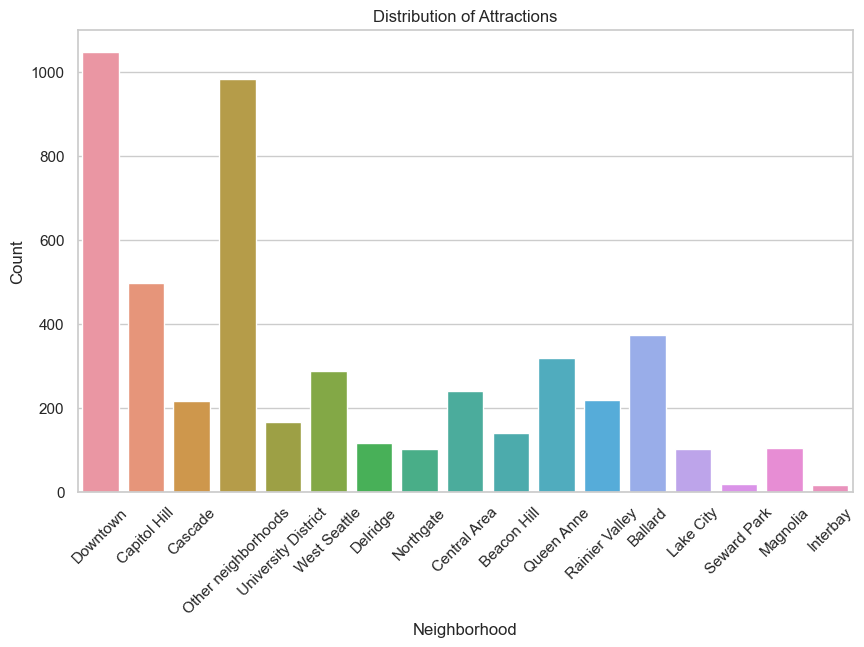

In [213]:
plt.figure(figsize=(10, 6))
sns.countplot(data=nbh_tab, x='neighborhood_group_cleansed')
plt.xticks(rotation=45)
plt.xlabel('Neighborhood')
plt.ylabel('Count')
plt.title('Distribution of Attractions')
plt.show()

In [38]:
fsq1 = fsq.merge(nbh_tab, on='fsq_id', how='inner')

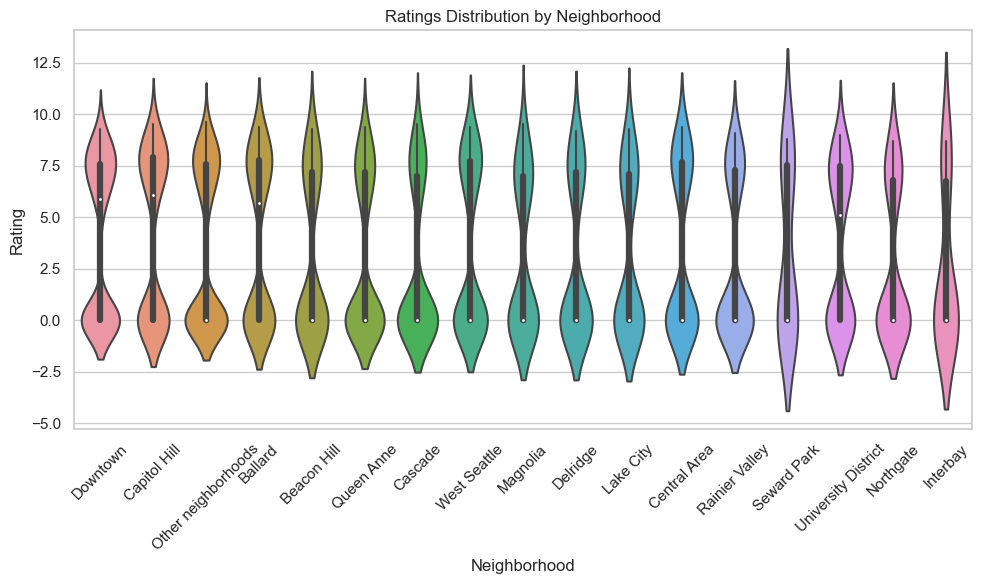

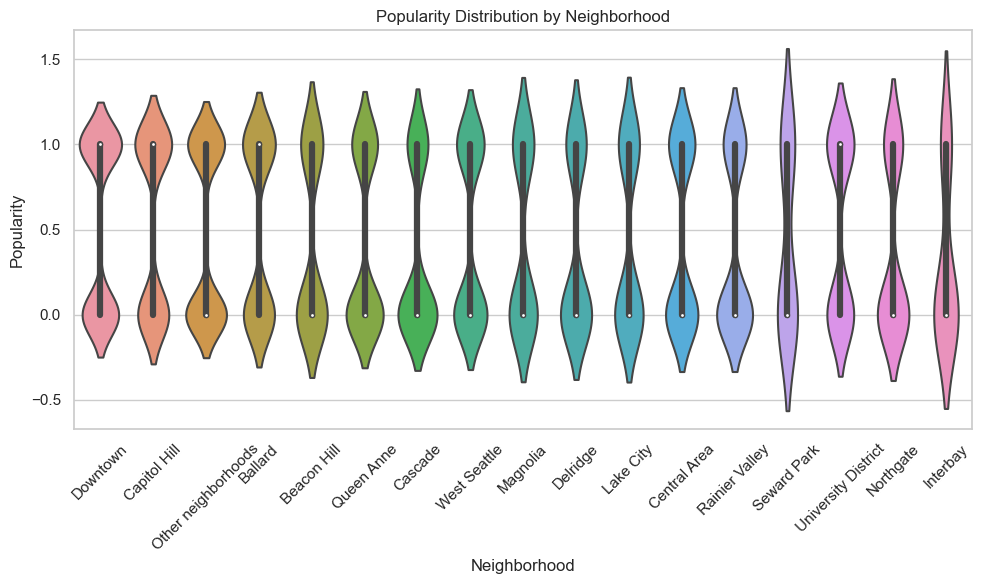

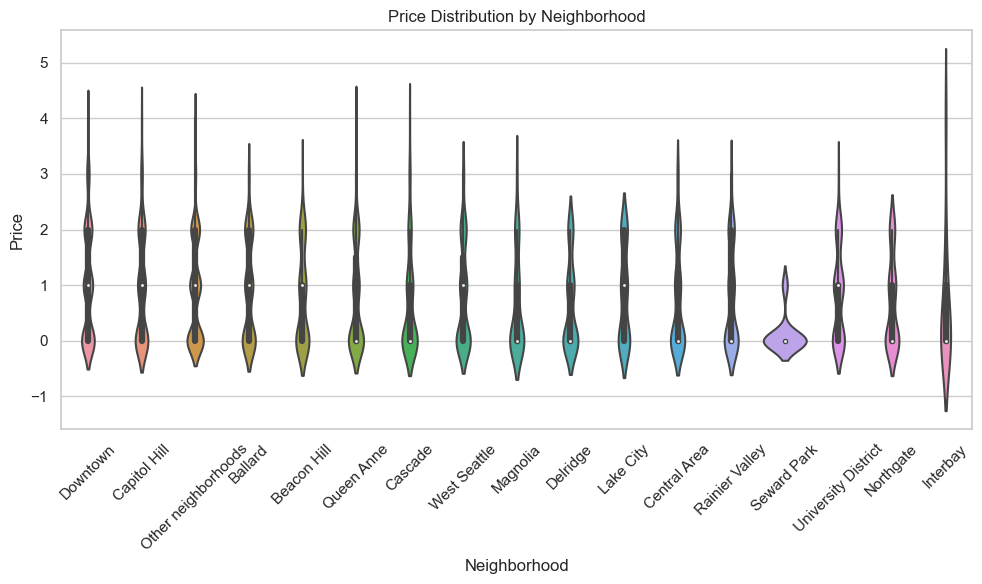

In [128]:
fsq1['rating'] = np.clip(fsq1['rating'], 0, 10)
plt.figure(figsize=(10, 6))
sns.violinplot(data=fsq1, x='neighborhood_group_cleansed', y='rating')
plt.title('Ratings Distribution by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a violin plot for 'popularity' for each neighborhood
fsq1['popularity'] = np.clip(fsq1['popularity'], 0, 1)
plt.figure(figsize=(10, 6))
sns.violinplot(data=fsq1, x='neighborhood_group_cleansed', y='popularity')
plt.title('Popularity Distribution by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Popularity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a violin plot for 'price' for each neighborhood
fsq1['price'] = np.clip(fsq1['price'], 0, 4)

plt.figure(figsize=(10, 6))
sns.violinplot(data=fsq1, x='neighborhood_group_cleansed', y='price')
plt.title('Price Distribution by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [124]:
data=fsq1
# Calculate the average price, rating, and popularity for each neighborhood

average_price = data.groupby('neighborhood_group_cleansed')['price'].mean()
average_rating = data.groupby('neighborhood_group_cleansed')['rating'].mean()
average_popularity = data.groupby('neighborhood_group_cleansed')['popularity'].mean()

# Sort the neighborhoods based on each metric
price = average_price.sort_values(ascending=False).to_frame().reset_index()
rating = average_rating.sort_values(ascending=False).to_frame().reset_index()
popularity = average_popularity.sort_values(ascending=False).to_frame().reset_index()

In [125]:
def drop_column_at_index(df, index_to_drop, df_name):
    """
    Drops the column at the specified index from the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        index_to_drop (int): The index of the column to be dropped.
        df_name (str): The name of the DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with the specified column dropped and renamed.
    """
    dropped_column_name = df.columns[index_to_drop]
    df = df.drop(dropped_column_name, axis=1)
    df.columns = [df_name if col == dropped_column_name else col for col in df.columns]
    return df

data_frames = [price, rating, popularity]
index_to_drop = 1

for i, df in enumerate(data_frames):
    df_name = f'data{i+1}'  # Generate the DataFrame name dynamically
    data_frames[i] = drop_column_at_index(df, index_to_drop, df_name)
    
attractions_ranked = pd.concat([price, rating, popularity], axis=1)
attractions_ranked

,neighborhood_group_cleansed,price,neighborhood_group_cleansed,rating,neighborhood_group_cleansed,popularity
0,Downtown,1.042980,Capitol Hill,4.160685,Capitol Hill,0.542339
1,Capitol Hill,0.943548,Downtown,3.999618,Downtown,0.536772
2,Ballard,0.895161,Ballard,3.911559,Ballard,0.513441
3,Other neighborhoods,0.864562,University District,3.642169,University District,0.506024
4,University District,0.819277,Other neighborhoods,3.586151,Other neighborhoods,0.475560
5,Lake City,0.811881,Central Area,3.483750,West Seattle,0.452962
6,West Seattle,0.794425,West Seattle,3.471777,Central Area,0.450000
7,Rainier Valley,0.775229,Seward Park,3.252632,Magnolia,0.432692
8,Central Area,0.766667,Beacon Hill,3.124823,Lake City,0.425743
9,Queen Anne,0.764890,Lake City,3.122772,Seward Park,0.421053


#### Feature Engineering a new metric to quantify the combined impact of prices, ratings and popularity

In [131]:
from sklearn.preprocessing import MinMaxScaler

fsq1['price_transformed'] = fsq1['price'].replace(0, 1)
scaler = MinMaxScaler()
fsq1[['popularity_scaled', 'rating_scaled']] = scaler.fit_transform(fsq1[['popularity', 'rating']])
fsq1['disappointment'] = (fsq1['popularity_scaled'] - fsq1['rating_scaled']) * fsq1['price_transformed']

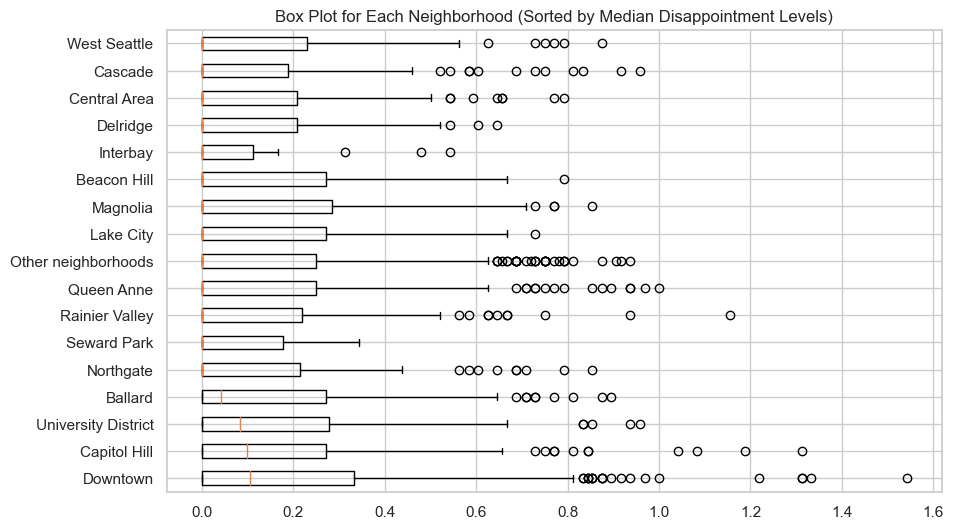

In [147]:
median_per_neighborhood = fsq1.groupby('neighborhood_group_cleansed')['disappointment'].median()
sorted_neighborhoods = median_per_neighborhood.sort_values(ascending=False).index
sorted_data = fsq1[fsq1['neighborhood_group_cleansed'].isin(sorted_neighborhoods)]

plt.figure(figsize=(10, 6))
plt.boxplot([sorted_data[sorted_data['neighborhood_group_cleansed'] == neighborhood]['disappointment'] for neighborhood in sorted_neighborhoods], vert=False)
plt.yticks(range(1, len(sorted_neighborhoods) + 1), sorted_neighborhoods)
plt.title('Box Plot for Each Neighborhood (Sorted by Median Disappointment Levels)')
plt.show()

### Apartments offering breakfast

In [219]:
df = listings[['id','neighbourhood_group_cleansed','property_type','price','accommodates']]
ammenities_only = pd.read_csv('categories detailed with price.csv')
ammenities_only.columns = [col.lower() for col in ammenities_only.columns]
ammenities_only = ammenities_only[['id','amenities without quotes']]

In [220]:
merged = pd.merge(df, ammenities_only, on='id', how='inner')
# merged_df.neighbourhood_group_cleansed.value_counts()
merged

,id,neighbourhood_group_cleansed,property_type,price,accommodates,amenities without quotes
0,241032,Queen Anne,Apartment,85.0,4,dryer
1,241032,Queen Anne,Apartment,85.0,4,heating
2,241032,Queen Anne,Apartment,85.0,4,internet
3,241032,Queen Anne,Apartment,85.0,4,kitchen
4,241032,Queen Anne,Apartment,85.0,4,tv
...,...,...,...,...,...,...
27831,10208623,Queen Anne,Apartment,87.0,3,iron
27832,10208623,Queen Anne,Apartment,87.0,3,kitchen
27833,10208623,Queen Anne,Apartment,87.0,3,shampoo
27834,10208623,Queen Anne,Apartment,87.0,3,tv


In [221]:
filter_condition = merged['amenities without quotes'] == 'breakfast'
filtered_df = merged[filter_condition]
lisitings_breakfast = filtered_df.drop_duplicates(subset=['id'])

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'accommodates'}>, <Axes: >]], dtype=object)

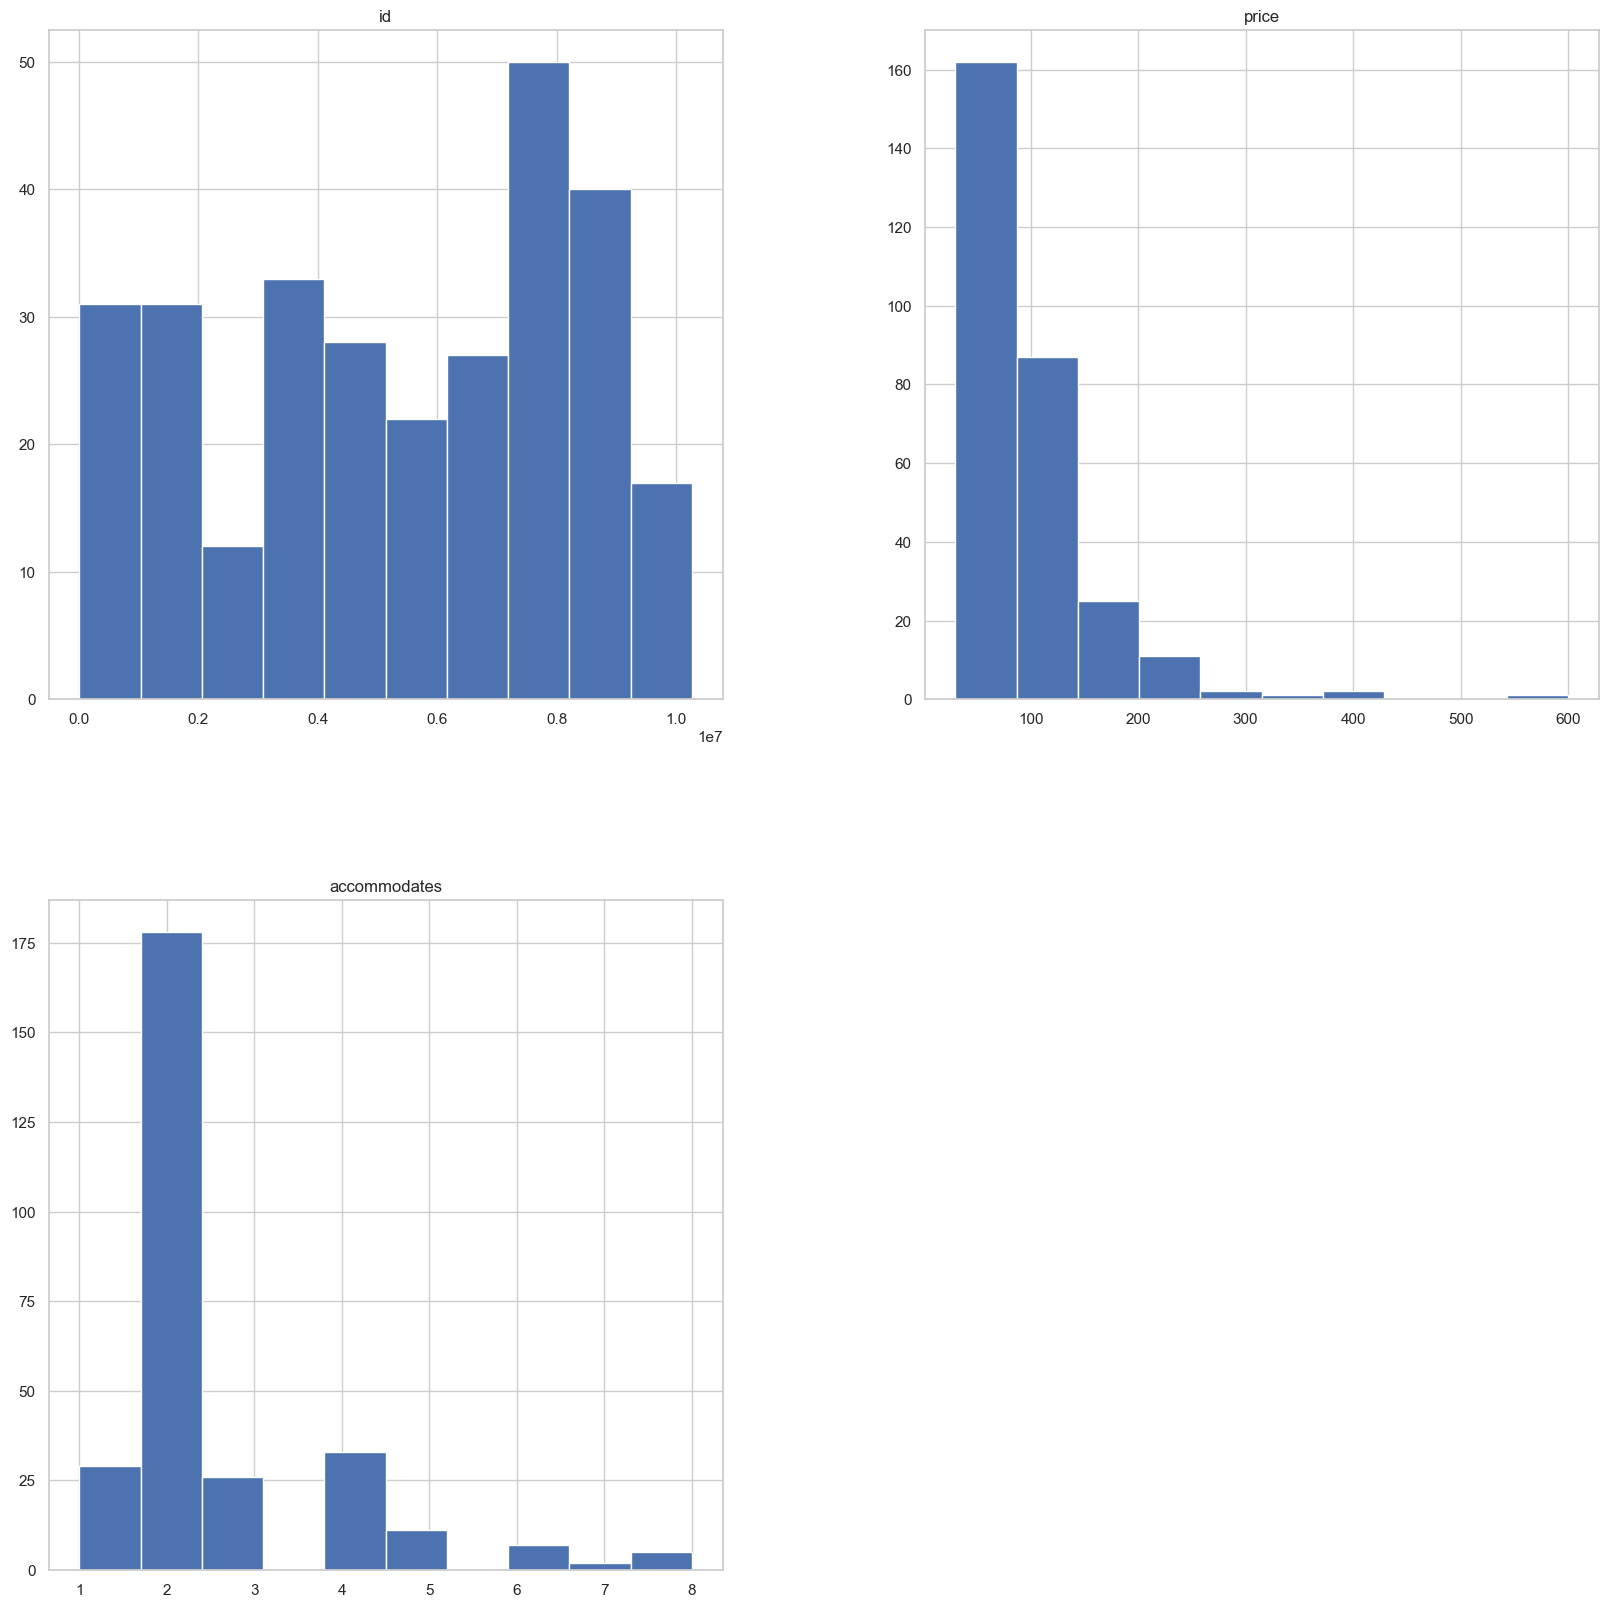

In [222]:
lisitings_breakfast = filtered_df.drop_duplicates(subset=['id'])
lisitings_breakfast.hist(figsize=(20, 20))

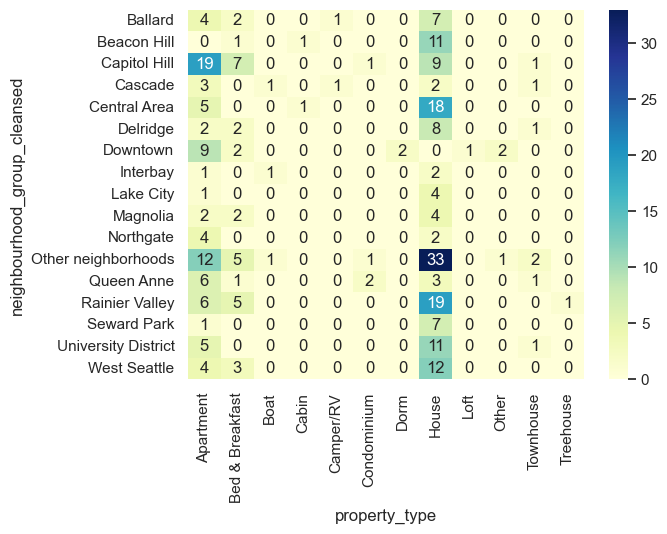

In [223]:
import seaborn as sns
import matplotlib.pyplot as plt

crosstab = pd.crosstab(lisitings_breakfast['neighbourhood_group_cleansed'], lisitings_breakfast['property_type'])
sns.heatmap(crosstab, annot=True, cmap='YlGnBu')
plt.show()

In [215]:
lisitings_breakfast.neighbourhood_group_cleansed.value_counts()

neighbourhood_group_cleansed
Other neighborhoods    55
Capitol Hill           37
Rainier Valley         31
Central Area           24
West Seattle           19
University District    17
Downtown               16
Ballard                14
Beacon Hill            13
Delridge               13
Queen Anne             13
Magnolia                8
Seward Park             8
Cascade                 8
Northgate               6
Lake City               5
Interbay                4
Name: count, dtype: int64

In [225]:
filter_condition2 = (lisitings_breakfast['neighbourhood_group_cleansed'] == 'Rainier Valley') | (lisitings_breakfast['neighbourhood_group_cleansed'] == 'Capitol Hill')

# Apply the filter
filtered_df2 = lisitings_breakfast[filter_condition2]

filtered_df2['price_per_head'] = filtered_df2['price'] / filtered_df2['accommodates']
Rainier = filtered_df2.neighbourhood_group_cleansed.isin("Rainier Valley")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_30136\4140103304.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df2['price_per_head'] = filtered_df2['price'] / filtered_df2['accommodates']


,id,neighbourhood_group_cleansed,property_type,price,accommodates,amenities without quotes,price_per_head
16049,4639040,Rainier Valley,Bed & Breakfast,39.0,1,breakfast,39.000000
16078,8409975,Rainier Valley,House,34.0,2,breakfast,17.000000
16086,8409926,Rainier Valley,House,35.0,3,breakfast,11.666667
16103,9797000,Rainier Valley,Apartment,75.0,4,breakfast,18.750000
16119,3372535,Rainier Valley,Bed & Breakfast,45.0,2,breakfast,22.500000
...,...,...,...,...,...,...,...
26317,8845144,Capitol Hill,Bed & Breakfast,138.0,2,breakfast,69.000000
26429,7151093,Capitol Hill,Bed & Breakfast,155.0,2,breakfast,77.500000
26460,2526405,Capitol Hill,House,80.0,2,breakfast,40.000000
26509,7824426,Capitol Hill,Apartment,85.0,2,breakfast,42.500000


In [237]:
Rainier = filtered_df2[filtered_df2.neighbourhood_group_cleansed.str.startswith("Rainier")]
Capitol  = filtered_df2[filtered_df2.neighbourhood_group_cleansed.str.startswith("Capitol")]

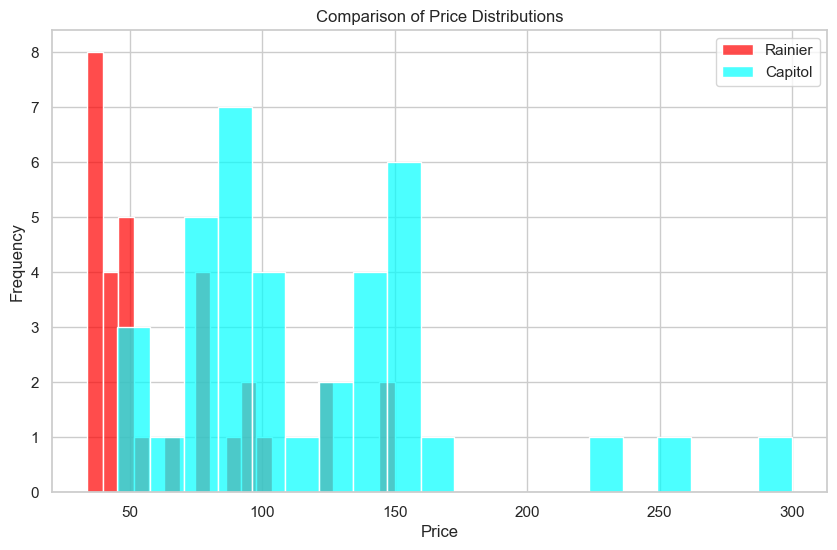

In [238]:
plt.figure(figsize=(10, 6))

# Overlay histograms or density plots using Seaborn
sns.histplot(data=Rainier, x='price', bins=20, color='red', label='Rainier', alpha=0.7)
sns.histplot(data=Capitol, x='price', bins=20, color='cyan', label='Capitol', alpha=0.7)

plt.title('Comparison of Price Distributions')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()

plt.show()
